### What keeps your eyes glued to the screen while you are watching a basketball game? 

Arguably, the answer is in the lines of
* your love for the game
* your support for one of the contending teams
* how hard-fought the game is

In this notebook, we will try to quantify the last point or, by abusing the terminology of the competition, define **how competitive a college basketball game can be**.

Trying to describe in numbers the emotion rushing through the crowd while the ball is flying towards the basket and ends in a buzzer-beater might be too ambitious. However, the core assumption of this notebook is that **a score for competitiveness can be extracted by observing how the game unfolded**. To do so, we will make extensive use of play-by-play data that tells us what happened during the game and when. For the past 6 Seasons, we have this information for both the Men's and the Women's tournaments and, while some [differences between the two tournaments can be found](https://www.kaggle.com/lucabasa/are-men-s-and-women-s-tournaments-different), we found that the way the game can unfold, either by turning out to be competitive or not, is the same for both. We will thus model them together as we are interested in finding out how to create such a score for a generic basketball game. 

This notebook is organized as follows

* **Data preparation**: everything can be found in [this utility script](https://www.kaggle.com/lucabasa/mm-data-manipulation) and the key concept will be summarized in this section.
* **A hard definition for a competitive game**: what conditions a game should satisfy to be considered competitive.
* **A score for competitiveness**: where a Machine Learning model will guide us towards the definition of our score.
* **Finding the Madness**: here we will analyse how the score relates to the key characteristics of a game.
* **Limits and next steps**: where we will conclude our journey.


# Data preparation

The functions that create the data we are going to use can be found in [this utility script](https://www.kaggle.com/lucabasa/mm-data-manipulation), where the non-trivial statistics were generated by following [these definitions](https://stats.nba.com/help/glossary/). In summary, 

* By using the scoring events, we get the game result during the game.
* We focus on 3 moments: the full game, the second half, the last 3 minutes.
* We get how many times the lead of the game changed in each of these (overlapping) periods.
* We aggregate and count the events in each period, for example the number of TO in the last 3 minutes.

Here a sample of the final result

In [1]:
!pip install pandas==1.0.3  # some conflicts with the matplotib version

import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.inspection import partial_dependence

import gc

# https://www.kaggle.com/lucabasa/mm-data-manipulation
from mm_data_manipulation import *
# https://www.kaggle.com/lucabasa/mm-plots
from mm_plots import *

pd.set_option("max_columns", 300)

kfolds = KFold(n_splits=5, shuffle=True, random_state=345)

     |████████████████████████████████| 10.0 MB 2.8 MB/s 
ERROR: pandas-profiling 2.5.0 has requirement pandas==0.25.3, but you'll have pandas 1.0.3 which is incompatible.
ERROR: hypertools 0.6.2 has requirement scikit-learn<0.22,>=0.19.1, but you'll have scikit-learn 0.22.2.post1 which is incompatible.
  Attempting uninstall: pandas
    Found existing installation: pandas 0.25.3
    Uninstalling pandas-0.25.3:
      Successfully uninstalled pandas-0.25.3


In [2]:
def prepare_competitive(league, events):
    if league == 'women':
        main_loc = '/kaggle/input/march-madness-analytics-2020/WDataFiles_Stage2/'
        regular_season = main_loc + 'WRegularSeasonDetailedResults.csv'
        playoff = main_loc + 'WNCAATourneyDetailedResults.csv'
        rank = None
        season_info = main_loc + 'WSeasons.csv'
    else:
        main_loc = '/kaggle/input/march-madness-analytics-2020/MDataFiles_Stage2/'
        regular_season = main_loc + 'MRegularSeasonDetailedResults.csv'
        playoff = main_loc + 'MNCAATourneyDetailedResults.csv'
        seed = main_loc + 'MNCAATourneySeeds.csv'
        rank = main_loc + 'MMasseyOrdinals.csv'
        season_info = main_loc + 'MSeasons.csv'
        
    reg = pd.read_csv(regular_season)
    reg = process_details(reg, rank)
    play = pd.read_csv(playoff)
    play = process_details(play)
    full = pd.concat([reg, play])
    
    to_use = [col for col in events if not col.endswith('_game') and 
              'FinalScore' not in col and 
              'n_OT' not in col and 
              '_difference' not in col]
    full = pd.merge(full, events[to_use], on=['Season', 'DayNum', 'WTeamID', 'LTeamID'])
    
    rolling = rolling_stats(full, season_info)
    
    
    competitive = events[['Season', 'DayNum', 'WTeamID', 'LTeamID', 
                          'tourney', 'Final_difference', 'Halftime_difference', '3mins_difference', 
                          'game_lc', 'half2_lc', 'crunchtime_lc', 'competitive']].copy()
    
    tmp = rolling.copy()
    tmp.columns = ['Season'] + \
                ['W'+col for col in tmp.columns if col not in ['Season', 'DayNum']] + ['DayNum']
    
    competitive = pd.merge(competitive, tmp, on=['Season', 'DayNum', 'WTeamID'])
    
    tmp = rolling.copy()
    tmp.columns = ['Season'] + \
                ['L'+col for col in tmp.columns if col not in ['Season', 'DayNum']] + ['DayNum']
    
    competitive = pd.merge(competitive, tmp, on=['Season', 'DayNum', 'LTeamID'])
    
    return competitive, full

In [3]:
all_events_m = []
all_events_m_plot = []
all_events_w = []
all_events_w_plot = []

for year in np.arange(2015, 2021):
    df = pd.read_csv(f'/kaggle/input/march-madness-analytics-2020/MPlayByPlay_Stage2/MEvents{year}.csv')
    df = make_scores(df)
    df = quarter_score(df)
    df = lead_changes(df)
    all_events_m_plot.append(df)
    df = event_count(df)
    all_events_m.append(df)
    gc.collect()
    df = pd.read_csv(f'/kaggle/input/march-madness-analytics-2020/WPlayByPlay_Stage2/WEvents{year}.csv')
    df = make_scores(df)
    df = quarter_score(df, men=False)
    df = lead_changes(df)
    all_events_w_plot.append(df)
    df = event_count(df)
    all_events_w.append(df)
    gc.collect()

all_events_m = pd.concat(all_events_m, ignore_index=True)
all_events_m_plot = pd.concat(all_events_m_plot, ignore_index=True)
all_events_w = pd.concat(all_events_w, ignore_index=True)
all_events_w_plot = pd.concat(all_events_w_plot, ignore_index=True)

all_events_m = make_competitive(all_events_m)
all_events_m_plot = make_competitive(all_events_m_plot)
all_events_w = make_competitive(all_events_w)
all_events_w_plot = make_competitive(all_events_w_plot)

In [4]:
comp_m, events_ext_m = prepare_competitive('men', all_events_m)
comp_w, events_ext_w = prepare_competitive('women', all_events_w)

In [5]:
all_events_m.sample(5)

,Season,DayNum,tourney,WTeamID,LTeamID,WFinalScore,LFinalScore,Final_difference,n_OT,Halftime_difference,3mins_difference,game_lc,half2_lc,crunchtime_lc,Wpoints_made_half2,Lpoints_made_half2,Wpoints_made_crunchtime,Lpoints_made_crunchtime,Wmade1_game,Lmade1_game,Wmade2_game,Lmade2_game,Wmade3_game,Lmade3_game,Wreb_game,Lreb_game,Wturnover_game,Lturnover_game,Wassist_game,Lassist_game,Wsteal_game,Lsteal_game,Wblock_game,Lblock_game,Wmade1_half2,Lmade1_half2,Wmade2_half2,Lmade2_half2,Wmade3_half2,Lmade3_half2,Wreb_half2,Lreb_half2,Wturnover_half2,Lturnover_half2,Wassist_half2,Lassist_half2,Wsteal_half2,Lsteal_half2,Wblock_half2,Lblock_half2,Wmade1_crunchtime,Lmade1_crunchtime,Wmade2_crunchtime,Lmade2_crunchtime,Wmade3_crunchtime,Lmade3_crunchtime,Wreb_crunchtime,Lreb_crunchtime,Wturnover_crunchtime,Lturnover_crunchtime,Wassist_crunchtime,Lassist_crunchtime,Wsteal_crunchtime,Lsteal_crunchtime,Wblock_crunchtime,Lblock_crunchtime,WAst_perc_game,LAst_perc_game,WFGM_perc_game,LFGM_perc_game,WFGM3_perc_game,LFGM3_perc_game,WFTM_perc_game,LFTM_perc_game,WAst_perc_half2,LAst_perc_half2,WFGM_perc_half2,LFGM_perc_half2,WFGM3_perc_half2,LFGM3_perc_half2,WFTM_perc_half2,LFTM_perc_half2,WAst_perc_crunchtime,LAst_perc_crunchtime,WFGM_perc_crunchtime,LFGM_perc_crunchtime,WFGM3_perc_crunchtime,LFGM3_perc_crunchtime,WFTM_perc_crunchtime,LFTM_perc_crunchtime,competitive
26091,2019,101,0,1453,1324,66,54,12,0.0,3.0,11.0,5,0,0.0,41.0,32.0,8.0,7.0,19,11,16,14,5,5,45,47,14,27,10,8,12,7,4,0,15,7,6,8,4,3,19,27,8,16,6,5,6,3,2,0,8,2,0,1,0,1,2,3,1,3,0,1,0,0,0,0,0.476190,0.421053,0.344262,0.345455,0.227273,0.185185,0.655172,0.647059,0.600000,0.454545,0.384615,0.366667,0.307692,0.176471,0.652174,0.700000,0.0,0.5,0.0,0.500000,0.0,0.333333,0.800000,1.000000,0
18260,2018,51,0,1385,1386,77,73,4,0.0,5.0,3.0,30,11,0.0,33.0,32.0,6.0,5.0,18,6,19,20,7,9,39,48,13,19,16,13,6,2,8,0,7,3,10,10,2,3,20,25,6,7,7,4,2,1,4,0,4,1,1,2,0,0,4,3,2,1,0,0,0,0,1,0,0.615385,0.448276,0.448276,0.414286,0.318182,0.272727,0.642857,0.600000,0.583333,0.307692,0.428571,0.371429,0.285714,0.200000,0.583333,0.600000,0.0,0.0,0.5,0.400000,0.0,0.000000,0.666667,0.500000,1
22674,2019,16,0,1339,1367,73,56,17,0.0,19.0,19.0,1,0,0.0,35.0,37.0,4.0,6.0,14,11,16,9,9,9,51,39,14,11,16,10,6,8,3,1,4,9,8,5,5,6,27,25,6,3,8,7,2,5,1,1,0,2,2,2,0,0,4,3,3,0,1,0,0,2,0,0,0.640000,0.555556,0.423729,0.276923,0.375000,0.272727,0.700000,0.785714,0.615385,0.636364,0.393939,0.314286,0.357143,0.315789,0.500000,0.750000,0.5,0.0,0.5,0.400000,0.0,0.000000,0.000000,0.666667,0
24658,2019,70,0,1313,1126,75,68,7,0.0,5.0,10.0,12,0,0.0,43.0,41.0,12.0,15.0,15,16,18,23,8,2,37,36,20,22,17,12,9,6,4,3,13,9,9,16,4,0,18,19,12,11,9,5,7,5,3,3,7,5,1,5,1,0,5,3,4,1,1,1,0,1,1,0,0.653846,0.480000,0.472727,0.471698,0.347826,0.142857,0.789474,0.571429,0.692308,0.312500,0.520000,0.516129,0.444444,0.000000,0.812500,0.562500,0.5,0.2,1.0,0.555556,1.0,0.000000,0.777778,0.714286,0
14031,2017,82,0,1249,1311,87,76,11,0.0,-6.0,9.0,10,7,0.0,55.0,36.0,11.0,9.0,23,17,20,16,8,9,45,35,12,13,13,16,4,5,4,2,14,10,9,10,7,2,26,13,4,4,10,7,1,1,0,1,8,4,0,1,1,1,4,2,1,0,1,2,0,0,0,0,0.464286,0.640000,0.518519,0.416667,0.363636,0.346154,0.657143,0.708333,0.625000,0.583333,0.592593,0.413793,0.583333,0.166667,0.666667,0.714286,1.0,1.0,1.0,0.333333,1.0,0.200000,0.800000,1.000000,0


We are ready to use these information about the over **63000 games played in the two leagues since 2015** to find out what *competitiveness* means.

# A hard definition of competitive games

In this section, we want to follow our intuition of how a competitive game looks like. The resulting label will be the key player in the next section's analysis. As we said before, we want to capture the effect of two teams going back and forth for the entire game, or maybe turning up the heat in the later stages. We don't want to rely solely on the final result as a game can be very hard-fought but one of the two teams can give up in the last few minutes and the final score would not reflect the competitiveness of the game.

We thus define a competitive game if it satisfies at least one of the following conditions:

* The two teams left the floor with at most 3 points of difference.
* The game was within 2 points 3 minutes to the end of regular time. 
* The game went to overtime.
* The game saw more than 20 lead changes in total, or more than 10 in the second half of the game, or more than 2 in the last 3 minutes.

The distribution of some of these characteristics in the games of the past 6 years is the following.

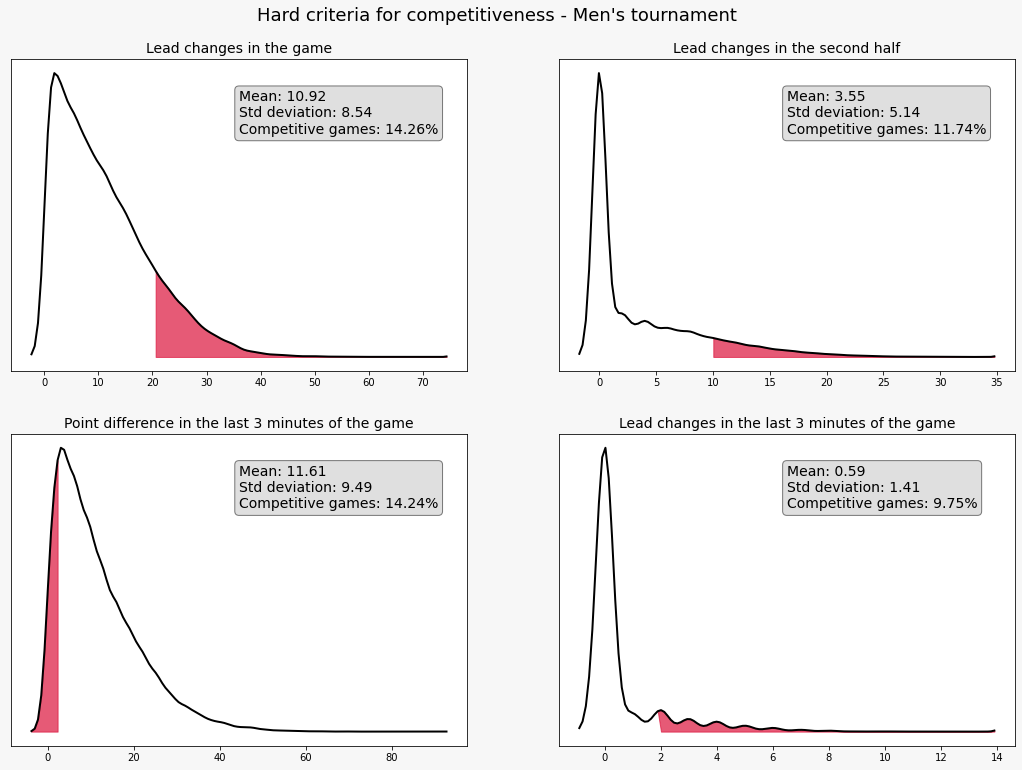

In [6]:
hardcuts_comp(all_events_m, "Hard criteria for competitiveness - Men's tournament")

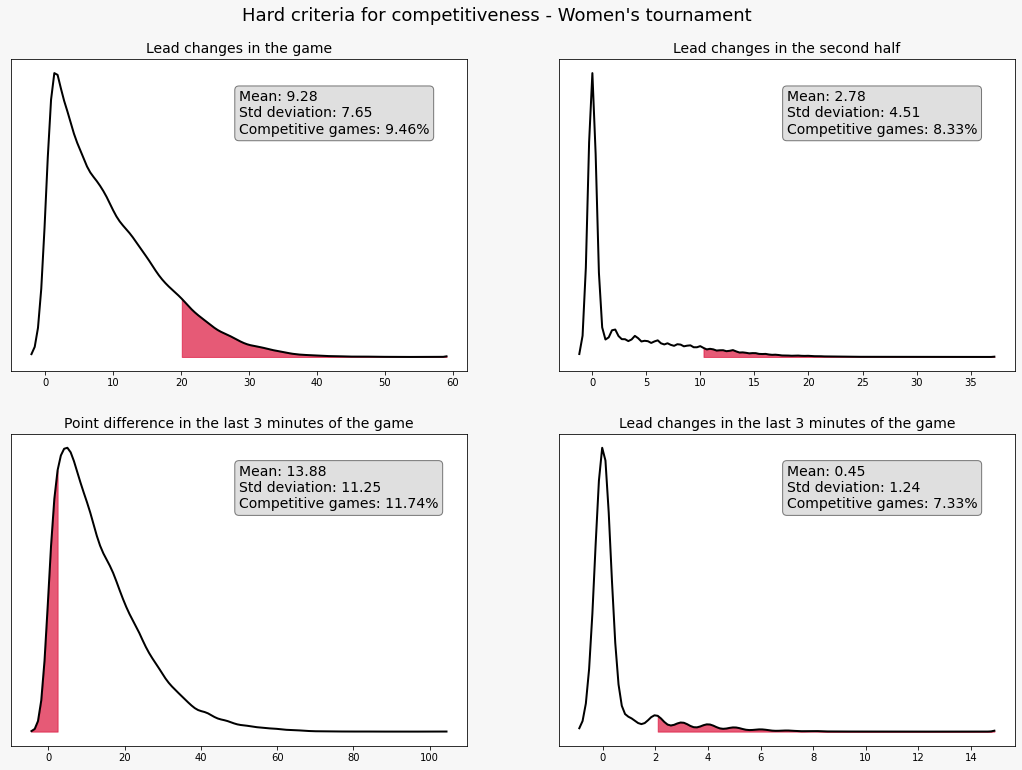

In [7]:
hardcuts_comp(all_events_w, "Hard criteria for competitiveness - Women's tournament")

Where in red we find the fraction of the games that satisfy the conditions above. We can see those games as the most competitive according to that particular criterium.

We see that the fraction of games satisfying these conditions is a bit higher in the Men's tournament, with a visible high point in the 2018 NCAA tourney. Looking at the [Kaggle competition of that year](https://www.kaggle.com/c/mens-machine-learning-competition-2018/leaderboard), it is also evident how harder it was to predict the outcome of the games of the tourney with respect to other years.

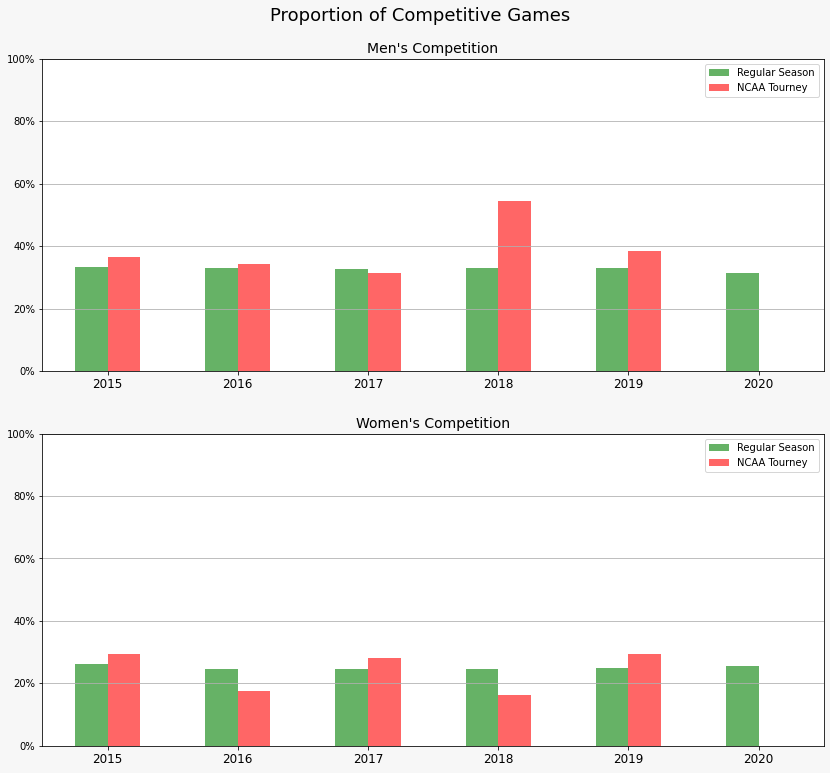

In [8]:
fig, ax = plt.subplots(2,1, figsize=(14, 12), facecolor='#f7f7f7')
fig.subplots_adjust(top=0.92)
fig.suptitle('Proportion of Competitive Games', fontsize=18)

tmp_m = all_events_m.copy()
tmp_m.tourney = tmp_m.tourney.map({0: 'Regular Season', 1: 'NCAA Tourney'})
tmp_w = all_events_w.copy()
tmp_w.tourney = tmp_w.tourney.map({0: 'Regular Season', 1: 'NCAA Tourney'})

tmp_m.groupby(['Season', 
               'tourney']).competitive.mean().unstack()[['Regular Season', 
                                                         'NCAA Tourney']].plot(kind='bar', 
                                                                               color=['g', 'r'], 
                                                                               alpha=0.6, 
                                                                               ax=ax[0])
tmp_w.groupby(['Season', 
               'tourney']).competitive.mean().unstack()[['Regular Season', 
                                                         'NCAA Tourney']].plot(kind='bar', 
                                                                               color=['g', 'r'], 
                                                                               alpha=0.6, 
                                                                               ax=ax[1])
ax[0].set_title("Men's Competition", fontsize=14)
ax[1].set_title("Women's Competition", fontsize=14)


for axes in ax:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=0, fontsize=12)
    axes.set_ylim((0,1))
    axes.set_yticklabels(['{:,.0%}'.format(x) for x in axes.get_yticks()])
    axes.set_xlabel('')
    axes.legend(title='', fancybox=True, fontsize=10)
    axes.grid(axis='y')

plt.show()

Interesting to notice how the fraction of competitive games stays about the same every regular season.

According to this definition, we can see how a non-competitive game looks like

In [9]:
names_m = pd.read_csv('/kaggle/input/march-madness-analytics-2020/MDataFiles_Stage2/MTeams.csv')
names_w = pd.read_csv('/kaggle/input/march-madness-analytics-2020/WDataFiles_Stage2/WTeams.csv')

all_names = pd.concat([names_m[['TeamID', 'TeamName']], names_w[['TeamID', 'TeamName']]])

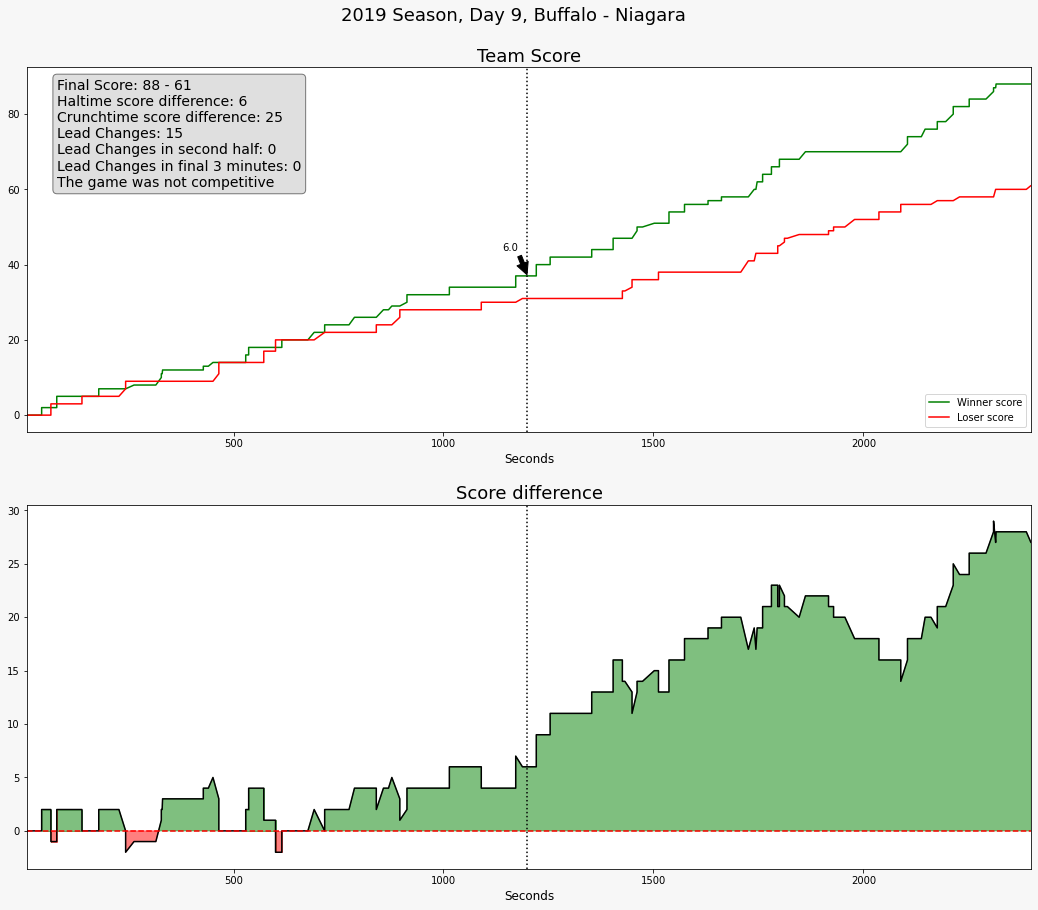

In [10]:
get_game(all_events_w_plot, all_names, final_score=20, final_smaller=False, use_competitive=True, competitive=False)

While a competitive game in the men's tournament looks like this

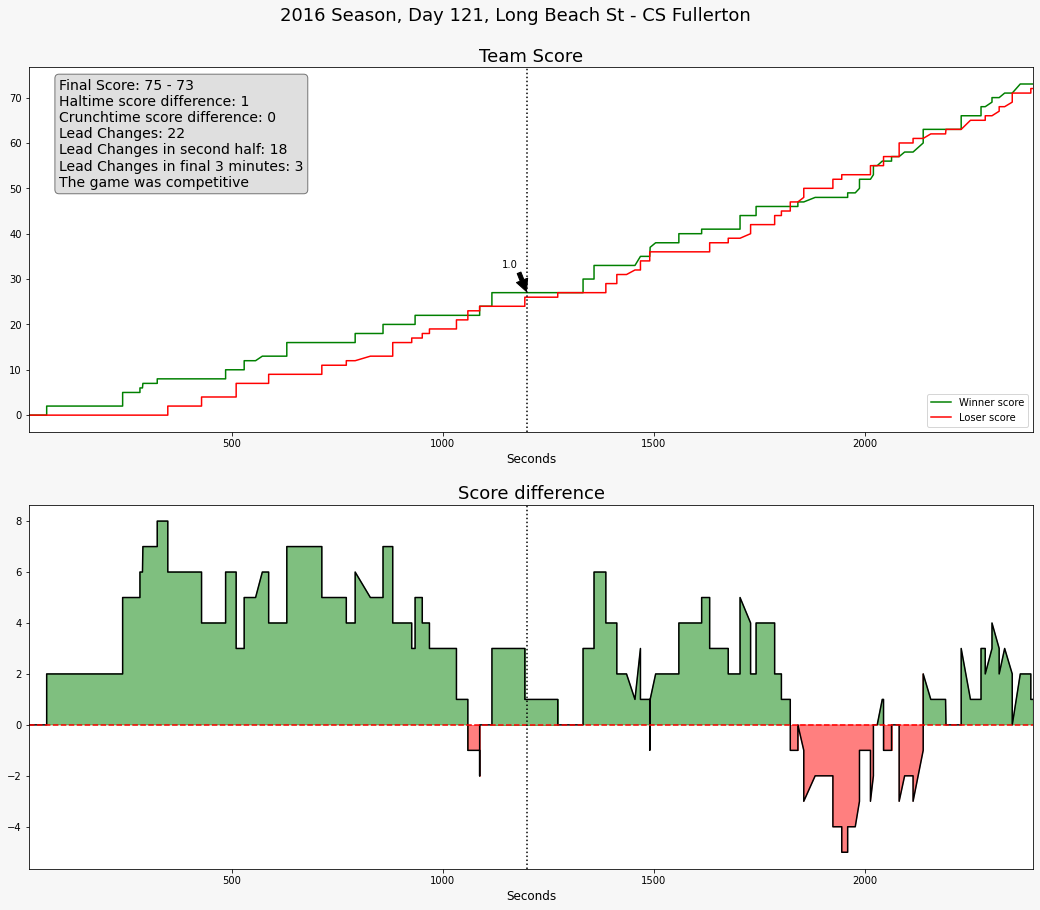

In [11]:
get_game(all_events_m_plot, all_names, half_score=3, final_smaller=True, use_competitive=True, competitive=True)

Out of curiosity, we can also find the game with most lead changes (56, with 5 OT) in the women's tournament, which naturally was very competitive.

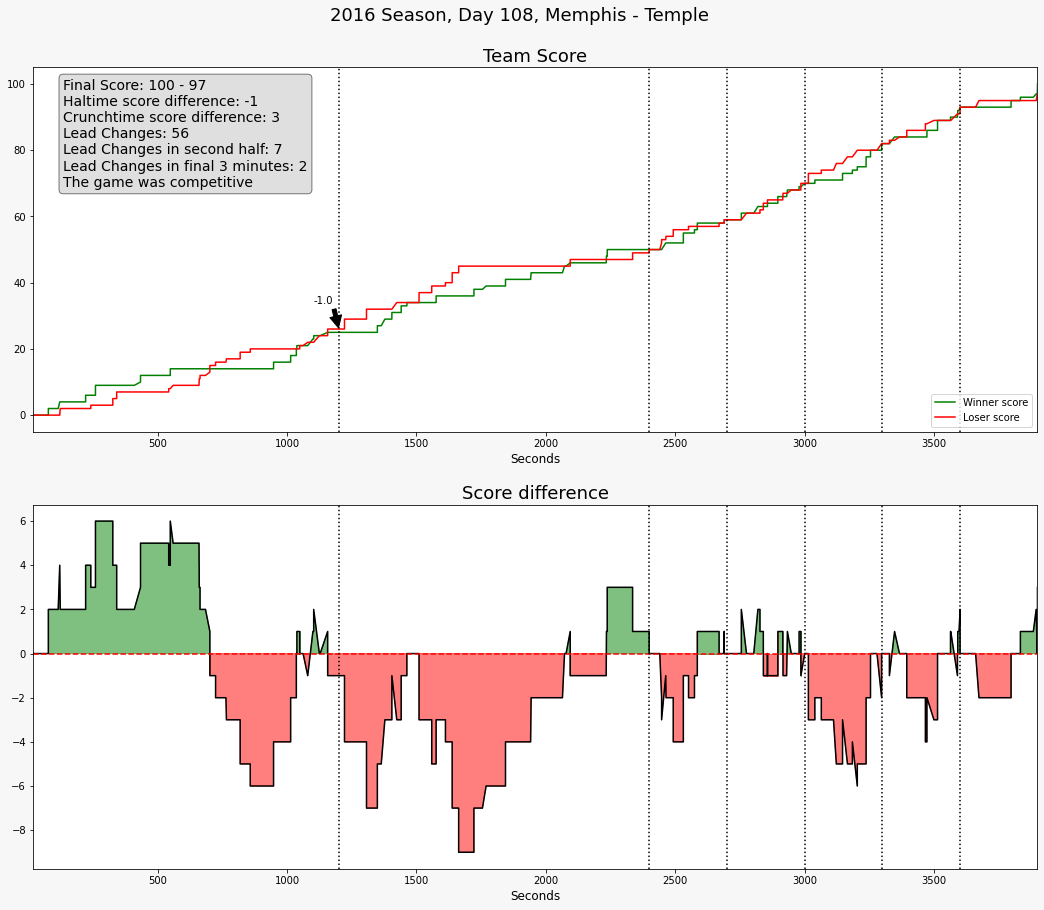

In [12]:
get_game(all_events_w_plot, all_names, game_lc=True)

All that being said, we can see a **limit in our definition of competitiveness**. For example, let's have a look at following game

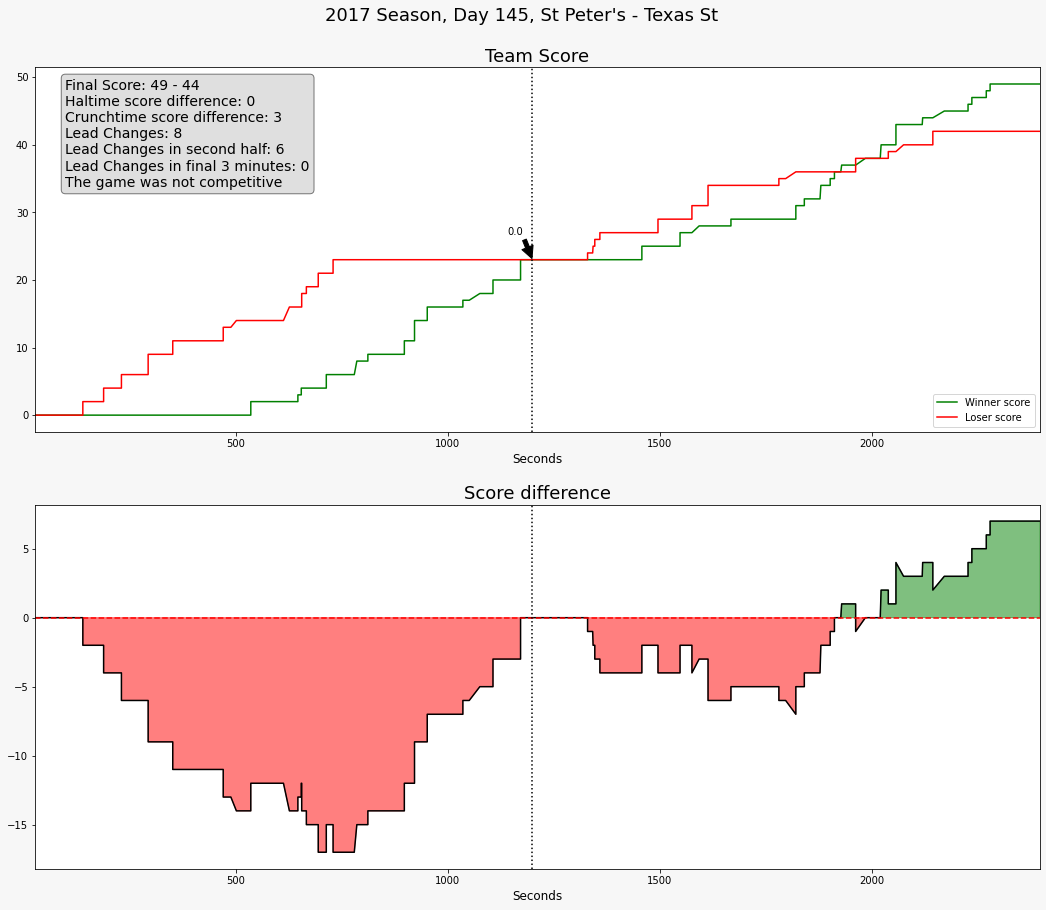

In [13]:
get_game(all_events_m_plot, all_names, half_score=2, half_smaller=True, crunch_score=3, crunch_smaller=True, use_competitive=True, competitive=False)

This game was **close at half time, close 3 minutes to the end, and yet not labeled as competitive** according to our definition.

# A score for competitiveness

In this section, we will train a Machine Learning model to learn the relation between game characteristics and the label for competitiveness we defined above. Including the features used to define the label, for example the point difference at the end of the game, would make this a fairly trivial exercise. Therefore we are not going to use them to train the model.

We will focus instead on features that might be directly related to these key characteristics (for example the difference between the Field Goal Made by the two teams is directly related to the final score) or with more indirect relation (like the number of Rebounds). The model is trained on 3 types of features:

* **Differences between the two teams in each statistic** (for example the difference in the number of Rebounds). We also take the absolute value of this difference as the data are provided by Winning and Losing teams, therefore the signs would also inform the model on who won the game and this score should be independent on that.
* **Total count of each statistic** (for example the total points made in the last 3 minutes).
* **Proportions**. This can be either the total proportion of shots that went in or features like the proportions of rebounds that happened in the second half.

To have a score on each game played in the past 6 years, we use a 5-fold validation scheme so that each score is predicted after using the other 4/5 of the available data, ensuring that each prediction is not done on the same data used for training. The algorithm used is an XGBoost Classifier and the final score is given by the probability of being competitive (according to our hard definition). In other words, **a very competitive game will have a score close to 1, while a non competitive one will have a score around 0**.

After training our model, we can have a look at the most relevant features and at how the score relates to the label we defined in the previous section.

In [14]:
def get_pdp(clf, feature, data, fold):
    val, exes = partial_dependence(clf, features=feature, 
                                   X=data, grid_resolution=50)
    fold_tmp = pd.DataFrame({'x': exes[0], 'y': val[0]})
    fold_tmp['feat'] = feature
    fold_tmp['fold'] = fold + 1
    
    return fold_tmp


def xgb_train(train, target, kfolds):

    oof = np.zeros(len(train))
    pd.options.mode.chained_assignment = None 
    
    feat_df = pd.DataFrame()
    feat_pdp = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(kfolds.split(train.values, target.values)):
        trn_data = train.iloc[trn_idx].copy()
        val_data = train.iloc[val_idx].copy()
        
        trn_target = target.iloc[trn_idx]
        val_target = target.iloc[val_idx]

        
        clf = XGBClassifier(objective='binary:logistic', 
                                       subsample=0.8,
                                       n_jobs=5, 
                                       max_depth=8, 
                                       learning_rate=0.05, 
                                       n_estimators=10000).fit(trn_data, 
                                                             trn_target,
                                                             eval_set=[(val_data, val_target)], 
                                                             eval_metric='logloss', 
                                                             early_stopping_rounds=100, 
                                                             verbose=False)
        # for each split, predict on the remaining fold
        oof[val_idx] = clf.predict_proba(val_data, ntree_limit=clf.best_iteration)[:,1]
        # For each split, calculate the pdp
        for feat in ['impact_diff', 'points_made_half2_diff', 'reb_crunchtime_tot', 'points_made_crunchtime_tot']:
            fold_tmp = get_pdp(clf, feat, trn_data, fold_)
            feat_pdp = pd.concat([feat_pdp, fold_tmp], axis=0)
        # For each split, store the feature importance
        fold_df = pd.DataFrame()
        fold_df["feat"] = trn_data.columns
        fold_df["score"] = clf.feature_importances_     
        fold_df['fold'] = fold_ + 1
        feat_df = pd.concat([feat_df, fold_df], axis=0)
       

    feat_df = feat_df.groupby('feat')['score'].agg(['mean', 'std'])
    feat_df['abs_sco'] = (abs(feat_df['mean']))
    feat_df = feat_df.sort_values(by=['abs_sco'],ascending=False)
    del feat_df['abs_sco']

    print("CV log loss: \t {:<8.5f}".format(log_loss(y_true=target, y_pred=oof)))
    print('CV accuracy: \t {:<8.5f}'.format(accuracy_score(y_true=target, y_pred=(oof>0.5).astype(int))))
    print('CV ROC_AUC: \t {:<8.5f}'.format(roc_auc_score(y_true=target, y_score=oof)))
    pd.options.mode.chained_assignment = 'warn'
    
    return oof, feat_df, feat_pdp

CV log loss: 	 0.28476 
CV accuracy: 	 0.87834 
CV ROC_AUC: 	 0.93749 


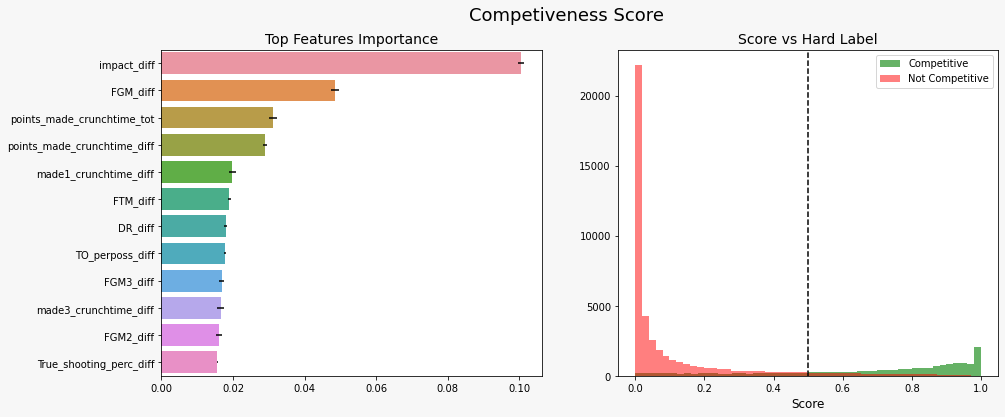

In [15]:
events_m = make_feats(events_ext_m)
events_w = make_feats(events_ext_w)

events_m['male'] = 1
events_w['male'] = 0

events_t = pd.concat([events_m, events_w])

# set of important features: totals, differences, and percentages
full_set = (['Season', 'DayNum', 'tourney', 'competitive', 'game_lc', 'half2_lc', 'crunchtime_lc', 'male', 'NumOT'] + 
            [col for col in events_m if '_tot' in col or '_diff' in col] + 
            ['OR_perc', 'points_half2_perc', 'points_crunchtime_perc', 'Shooting_perc', 'Ast_perc', 'Stl_TO', 
             'reb_half2_perc', 'reb_crunchtime_perc', 'block_half2_perc', 
             'block_crunchtime_perc', 'steal_half2_perc', 'steal_crunchtime_perc'])

not_use = ['game_lc', 'half2_lc', 'crunchtime_lc', 'Score_diff', 'NumOT', 'off_rating_diff']  # features used to define the label explictly
# offensive rating is too directly related to the final score

custom_set = [col for col in full_set if col not in not_use]

# model training and predictions
oof, feat_imp, pdps = xgb_train(events_t[custom_set].drop('competitive', axis=1), events_t.competitive, kfolds)


# Plot feature importance and prediction vs label
fig, ax = plt.subplots(1,2, figsize=(15, 6), facecolor='#f7f7f7')
    
df = pd.DataFrame()
df['true'] = events_t.competitive
df['Prediction'] = oof

df[df.true==1]['Prediction'].hist(bins=50, ax=ax[1], alpha=0.6, color='g', label='Competitive')
df[df.true==0]['Prediction'].hist(bins=50, ax=ax[1], alpha=0.5, color='r', label='Not Competitive')

ax[1].axvline(0.5, color='k', linestyle='--')

sns.barplot(x="mean", y="feat", ax=ax[0],
            data=feat_imp.head(12).reset_index(), 
            xerr=feat_imp.head(12)['std'])

ax[1].set_title('Score vs Hard Label', fontsize=14)
ax[1].set_xlabel('Score', fontsize=12)
ax[1].grid(False)
ax[1].legend()

ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_title('Top Features Importance', fontsize=14)


fig.suptitle('Competiveness Score', fontsize=18)
plt.show()

We see that the model is learning the data fairly well, although it misclassifies about 13% of the games. In the next section, we will have a look at some of these games to understand if they are indeed misclassified or rather mislabeled.

The most important feature, here generically called `impact_diff` (being the difference in impact of the 2 teams), is the team version of the Player Impact Estimate and it is defined by
$$
impact_{diff} = PTS_{diff} + FGM_{diff} + FTM_{diff} - FGA_{diff} - FTA_{diff} + DREB_{diff} + \frac{1}{2} OREB_{diff} + \\ AST_{diff} + STL_{diff} + \frac{1}{2} BLK_{diff} - PF_{diff} - TO_{diff}\,.
$$

To better understand how the model creates the final score, we have a look at the **partial dependence plots**, which show the marginal effect of each feature on the predicted outcome. Some interesting patterns are

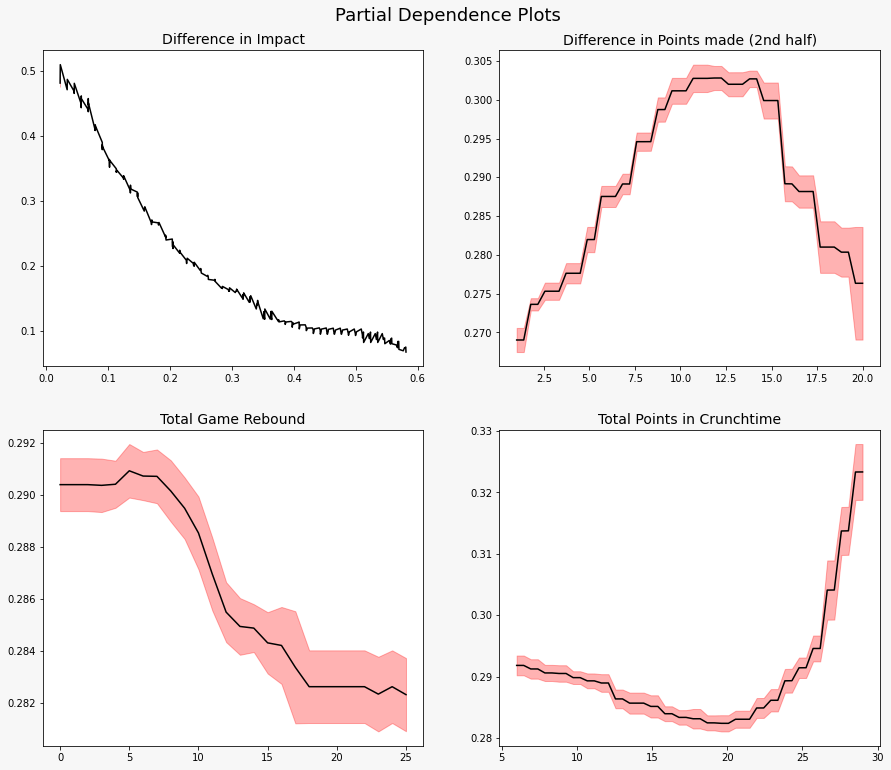

In [16]:
def plot_pdp(data, feature, title, axes):
    data[data.feat==feature].plot(ax=axes, x='x', y='mean', color='k')
    axes.fill_between(data[data.feat==feature].x, (data[data.feat==feature]['mean'] - data[data.feat==feature]['std']).astype(float),
                                (data[data.feat==feature]['mean'] + data[data.feat==feature]['std']).astype(float), alpha=0.3, color='r')
    axes.set_title(title, fontsize=14)
    axes.legend().set_visible(False)
    axes.set_xlabel('')
    return axes

tmp = pdps.groupby(['feat', 'x']).y.agg(['mean', 'std']).reset_index() # mean and std across the 5 folds

fig, ax = plt.subplots(2,2, figsize=(15, 12), facecolor='#f7f7f7')
fig.subplots_adjust(top=0.93)
fig.suptitle('Partial Dependence Plots', fontsize=18)

ax[0][0] = plot_pdp(tmp, 'impact_diff', 'Difference in Impact', ax[0][0])
ax[0][1] = plot_pdp(tmp, 'points_made_half2_diff', 'Difference in Points made (2nd half)', ax[0][1])
ax[1][0] = plot_pdp(tmp, 'reb_crunchtime_tot', 'Total Game Rebound', ax[1][0])
ax[1][1] = plot_pdp(tmp, 'points_made_crunchtime_tot', 'Total Points in Crunchtime', ax[1][1])

plt.show()

The way the difference in points made in the second half is influencing the competitiveness score is particularly interesting. When the two teams score about the same number of points in the second half, thus in the lower end of the graph, we have that this feature contributes very little to the score. This can be interpreted as **a game already decided in the first half**, a game where the two teams are simply cruising to the final buzzer. We see how the competitiveness is increasing the more this difference increases, which can indicate a team making a **great comeback** after a disappointing first half. Then, when the difference gets above 15, the competitiveness drops again, maybe indicating a **blowout**.

Other features play a more obvious role. For example, we see the negative effect of having more and more rebounds in the game because this means that we simply have **more and more missed shots**. Or how having a large number of points scored after the 37th minute mark is increasing the level of competitiveness, most likely indicating a game going to overtime.

At last, it becomes clear why Impact is our most important feature. It contains all the important aspects of team performance, including one of the features used to define the target label. We decided to keep it in the model because the presence of several statistics together was letting the model learn more complex relations while maintaining the general intuition that the **closer two teams are, the more the game is competitive**.

# Finding the Madness

We have now a score that aims to capture aspects of competitiveness more complex than the intuitive but simple hard cuts we made in the first place. Naturally, this score is severely affected by the choice of these hard cuts. Therefore, it makes sense to have a look at how the competitiveness score changes when these statistics, which were *not* used to train the model, change.

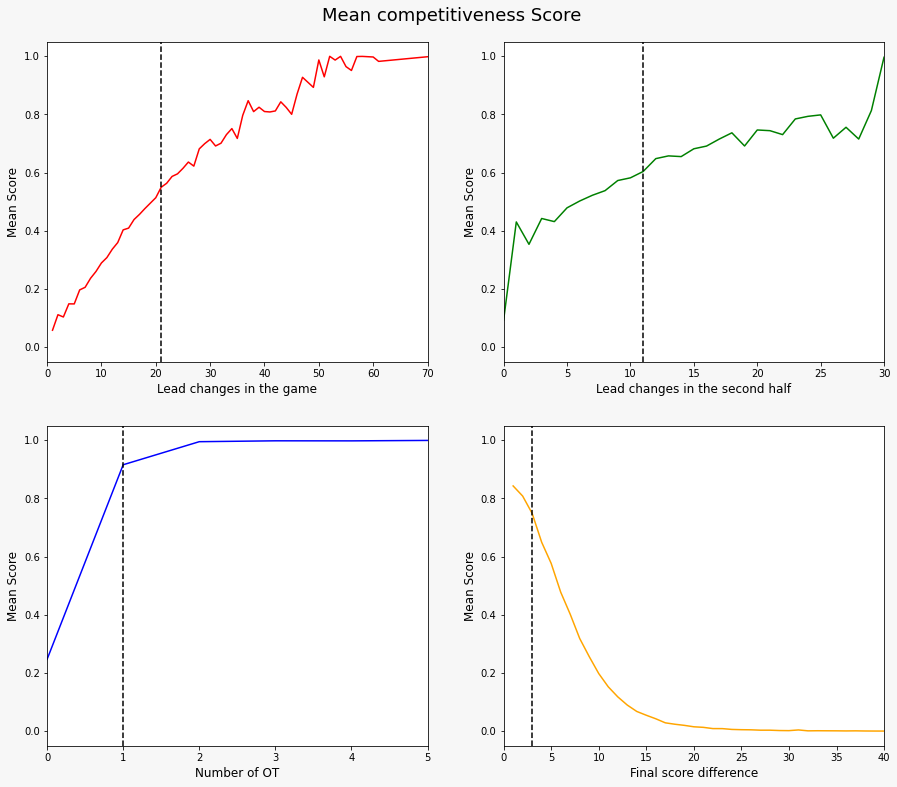

In [17]:
# adding the score to the games
ids = events_t[['Season', 'DayNum', 'WTeamID', 'LTeamID', 'tourney', 'male', 'game_lc', 'half2_lc', 'crunchtime_lc', 'competitive', 'Score_diff', 'NumOT']].copy()
ids['competitive_score'] = oof

fig, ax = plt.subplots(2,2, figsize=(15, 12), facecolor='#f7f7f7')
fig.subplots_adjust(top=0.94)

ids.groupby('game_lc').competitive_score.mean().plot(ax=ax[0][0], color='r')
ax[0][0].axvline(21, color='k', linestyle='--')
ax[0][0].set_xlim((0,70))
ax[0][0].set_ylim((-0.05,1.05))
ids.groupby('half2_lc').competitive_score.mean().plot(ax=ax[0][1], color='g')
ax[0][1].axvline(11, color='k', linestyle='--')
ax[0][1].set_xlim((0,30))
ax[0][1].set_ylim((-0.05,1.05))
ids.groupby('NumOT').competitive_score.mean().plot(ax=ax[1][0], color='b')
ax[1][0].axvline(1, color='k', linestyle='--')
ax[1][0].set_xlim((0,5))
ax[1][0].set_ylim((-0.05,1.05))
ids.groupby('Score_diff').competitive_score.mean().plot(ax=ax[1][1], color='orange')
ax[1][1].axvline(3, color='k', linestyle='--')
ax[1][1].set_xlim((0,40))
ax[1][1].set_ylim((-0.05,1.05))

ax[0][0].set_xlabel('Lead changes in the game', fontsize=12)
ax[0][1].set_xlabel('Lead changes in the second half', fontsize=12)
ax[1][0].set_xlabel('Number of OT', fontsize=12)
ax[1][1].set_xlabel('Final score difference', fontsize=12)
ax[0][0].set_ylabel('Mean Score', fontsize=12)
ax[0][1].set_ylabel('Mean Score', fontsize=12)
ax[1][0].set_ylabel('Mean Score', fontsize=12)
ax[1][1].set_ylabel('Mean Score', fontsize=12)

fig.suptitle('Mean competitiveness Score', fontsize=18)
plt.show()

We called *competitive* any game that had at least 20 lead changes and we see now that our score is passing the 0.5 mark around the 20th lead change. This is a very interesting consequence of our model's predictions as it had no direct information about how many times the two teams went back and forth and yet its score has a very intuitive relation with the lead changes. Moreover, the score is giving a **nuanced description** of the difference between a game with, say, 10 lead changes and one with 15, something that was not possible with the hard-cut definition. We also observe some fluctuations at the high end of the graph but this is due to the fact that there are not many games with more than 40 lead changes and the plot is displaying an average taken on very few data points.

Secondly, our model is now describing the difference between games with zero, one, or more OT, following the logic that the big difference is between having or not an overtime.

At last, we see how much smoother is the curve for the final score difference that is, rightfully, saying that there is no chance of having a competitive game if it ended with more than 20 points of difference. 

We can see the distribution of the score difference and lead changes and see how the 10000 most competitive games compare to the least 10000 ones.

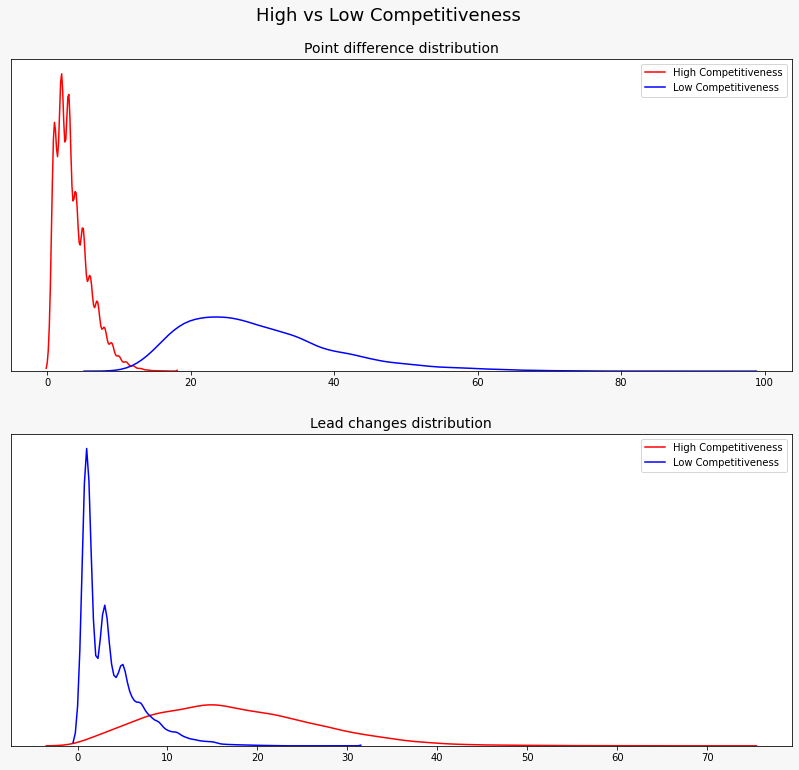

In [18]:
fig, ax = plt.subplots(2,1, figsize=(14, 12), facecolor='#f7f7f7')
fig.subplots_adjust(top=0.92)
fig.suptitle('High vs Low Competitiveness', fontsize=18)

high = ids.sort_values('competitive_score', ascending=False).head(10000)
low = ids.sort_values('competitive_score', ascending=False).tail(10000)

sns.kdeplot(high.Score_diff, ax=ax[0], label='High Competitiveness', color='r')
sns.kdeplot(low.Score_diff, ax=ax[0], label='Low Competitiveness', color='b')

sns.kdeplot(high.game_lc, ax=ax[1], label='High Competitiveness', color='r')
sns.kdeplot(low.game_lc, ax=ax[1], label='Low Competitiveness', color='b')

ax[0].set_title('Point difference distribution', fontsize=14)
ax[1].set_title('Lead changes distribution', fontsize=14)
ax[0].get_yaxis().set_ticks([])
ax[1].get_yaxis().set_ticks([])

plt.show()

Again, we see how this score is indicating as competitive or not also games that do not check all the boxes, which was the purpose of creating the score rather than a label. Indeed, we see how some of the least competitive games had the two teams within less than 10 points. Or how some of the most competitive games had no lead changes at all!

We can then have a look at one of the most competitive games in the **women's tournament** (a score above 0.99)

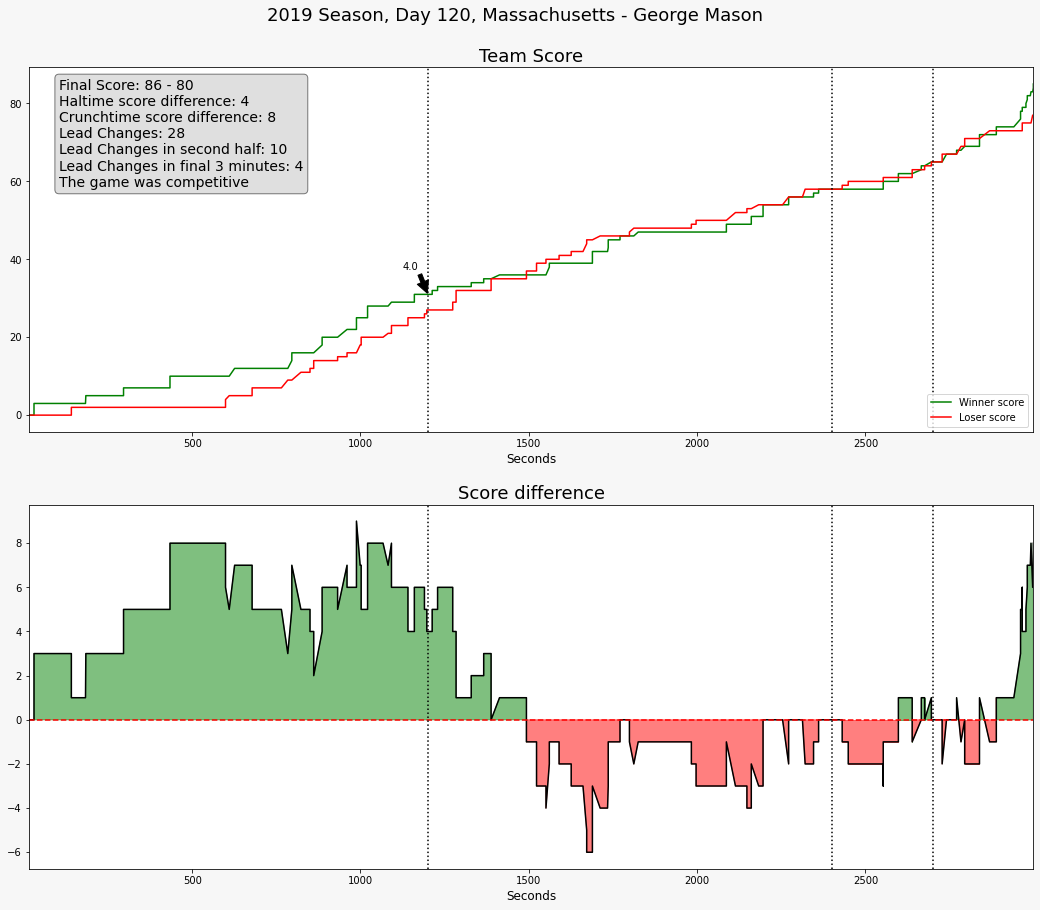

In [19]:
plot_game(all_events_w_plot, all_names, 2019, 120, 3269, 3206)

Similarly, one of the most competitive games (a score above 0.99) in the **men's tournament** is

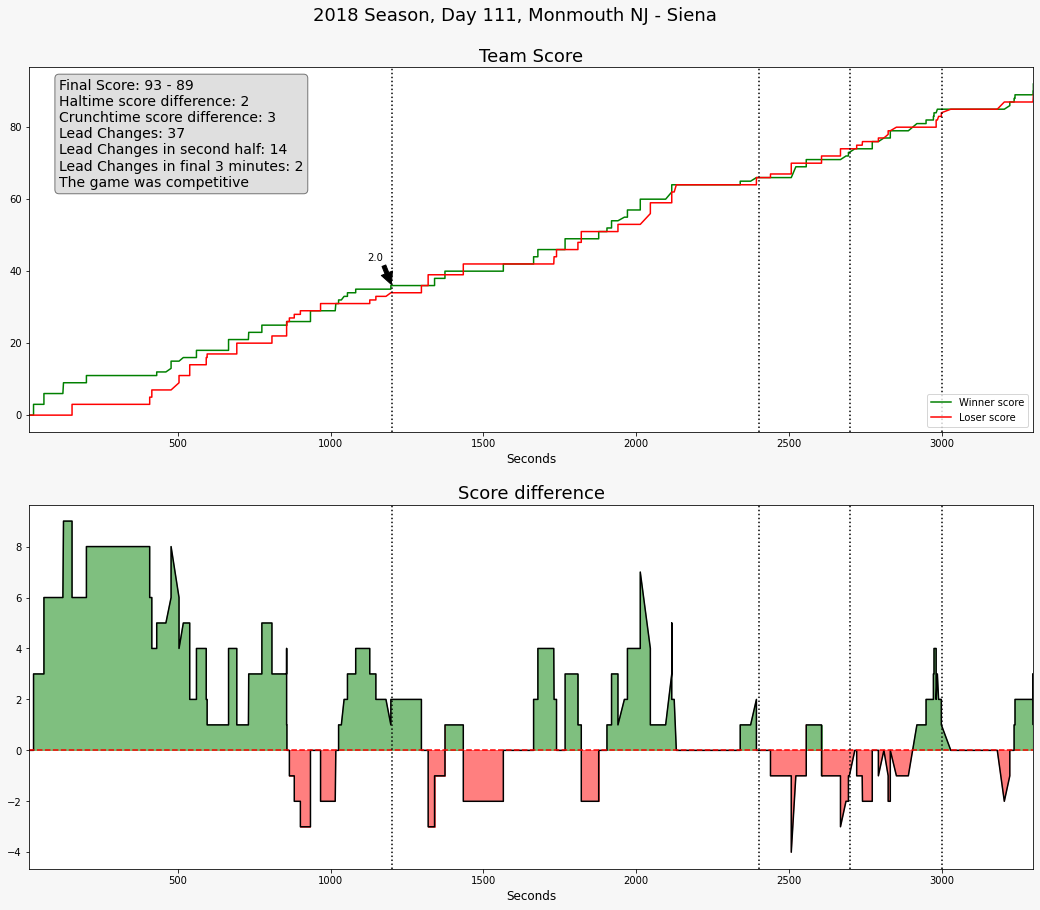

In [20]:
plot_game(all_events_m_plot, all_names, 2018, 111, 1284, 1373)

At last, we want to address some examples of games that got *misclassified* by our model. The first example, is a game that was **not** supposed to be competitive according to our definition, but ended up with **high competitiveness score** (0.98, the highest scoring *false positive*). It is Georgia Tech vs Florida State of 2015 men's tournament

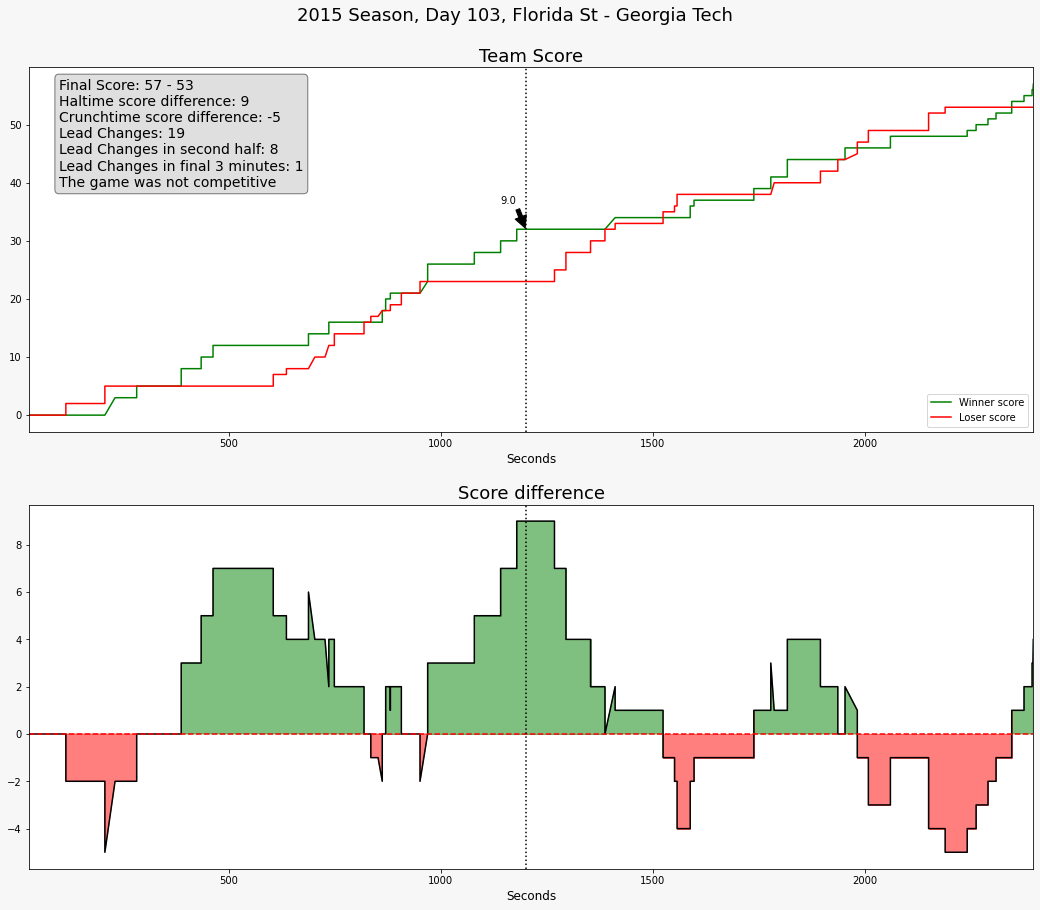

In [21]:
plot_game(all_events_m_plot, all_names, 2015, 103, 1199, 1210)

We see how Georgia Tech came back in the second half from a 9 points deficit, firing up a back-and-forth game in which Florida State got the upper hand only in the last few minutes.

Similarly, we can have a look at a game that was supposed to be competitive, but ended up with a **low competitive score** (0, the lowest scoring *false negative*). It is Oregon-Stanford of the 2020 women's tournament.

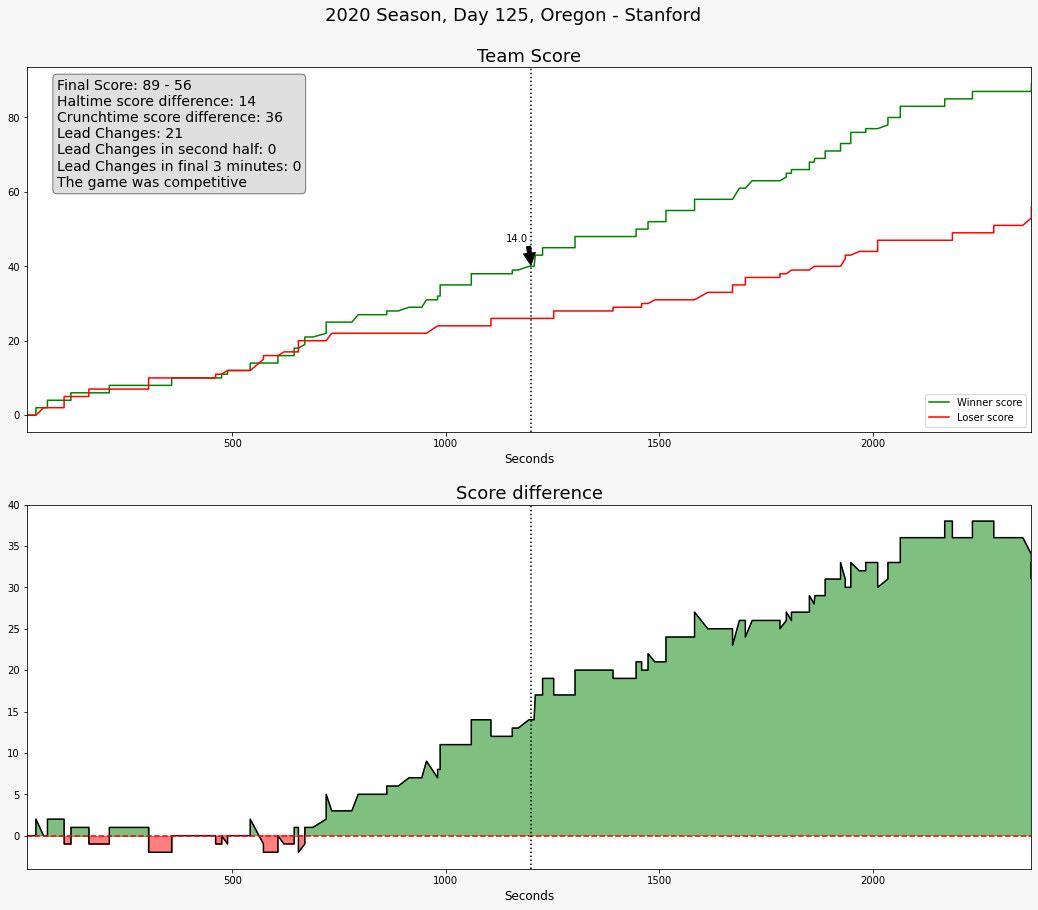

In [22]:
plot_game(all_events_w_plot, all_names, 2020, 125, 3332, 3390)

We see that indeed the game had a lot of lead changes (which is why it was labeled as competitive in the first place) but then Oregon took over, never look back, and won by a mile.

Naturally, there are some games for which deciding if it was a case of misclassification or mislabeling is more difficult but we can say that at the extremes we mostly find **mislabeled** games, i.e. games for which the hard-cuts definition of *competitive* was inadequate and for which the predicted score is a much better descriptor of the games' *competitiveness*.

# Conclusions, limits, and next steps

In this notebook, we started with an intuitive definition of *competitiveness* and used machine learning to find the relation between our intuition and the core statistics of a basketball game. Doing so, we are now able to better describe how a hard-fought game looks like and our model showed us examples of how our intuition was sometimes wrong.

Naturally, this process is highly dependent on the initial definition and this can be seen by plotting the average score across seasons, which very much looks like the average target levels we have seen at the beginning of our analysis.

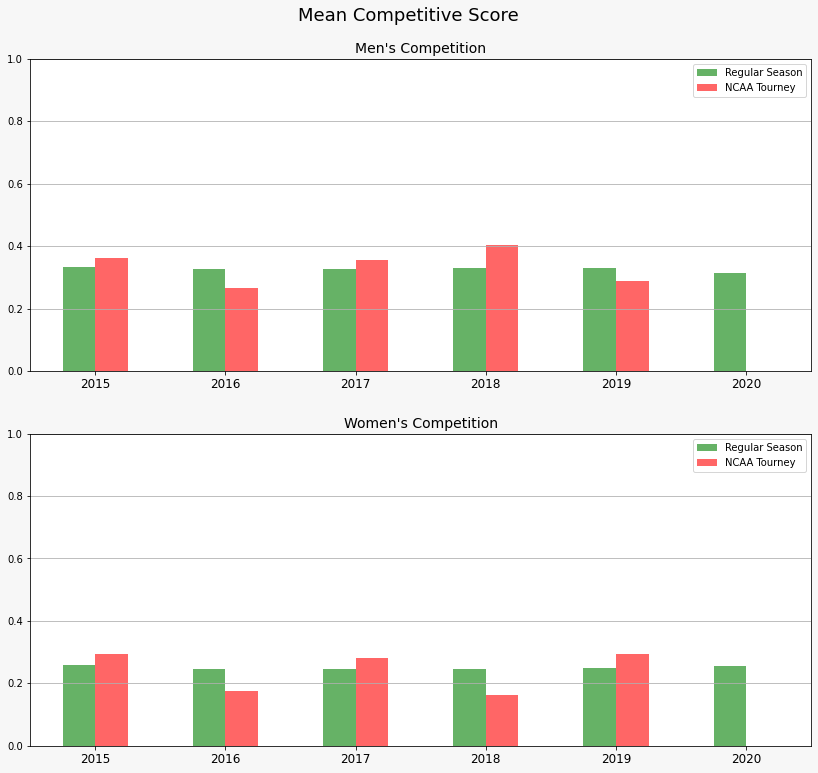

In [23]:
fig, ax = plt.subplots(2,1, figsize=(14, 12), facecolor='#f7f7f7')
fig.subplots_adjust(top=0.92)
fig.suptitle('Mean Competitive Score', fontsize=18)

tmp_m = ids[ids.male==1].copy()
tmp_m.tourney = tmp_m.tourney.map({0: 'Regular Season', 1: 'NCAA Tourney'})
tmp_w = ids[ids.male==0].copy()
tmp_w.tourney = tmp_w.tourney.map({0: 'Regular Season', 1: 'NCAA Tourney'})

tmp_m.groupby(['Season', 
               'tourney']).competitive.mean().unstack()[['Regular Season', 
                                                         'NCAA Tourney']].plot(kind='bar', 
                                                                               color=['g', 'r'], 
                                                                               alpha=0.6, 
                                                                               ax=ax[0])
tmp_w.groupby(['Season', 
               'tourney']).competitive.mean().unstack()[['Regular Season', 
                                                         'NCAA Tourney']].plot(kind='bar', 
                                                                               color=['g', 'r'], 
                                                                               alpha=0.6, 
                                                                               ax=ax[1])
ax[0].set_title("Men's Competition", fontsize=14)
ax[1].set_title("Women's Competition", fontsize=14)


for axes in ax:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=0, fontsize=12)
    axes.set_ylim((0,1))
    axes.set_xlabel('')
    axes.legend(title='', fancybox=True, fontsize=10)
    axes.grid(axis='y')

plt.show()

Therefore, more experienced sports enthusiasts can find better hard-cut definitions of *competitive* to get even richer results. However, it is interesting to notice how also the score we generated is indicating the 2018 Men's NCAA Tourney as a particularly competitive one, reflected for example into the somewhat lower performance of the [Kaggle community](https://www.kaggle.com/c/mens-machine-learning-competition-2018/leaderboard) as a whole in predicting that year's game with respect to other editions. 

Another limitation that we should address is that our model is trained by using features that indirectly relate to the ones used to generate the label (for example, the difference in the number of Assists is very related to the final score difference which was used in defining the target). Being more strict in the feature selection would lead to a model that misclassifies about 10% more games (thus about 20-25% of misclassified in total). Manual inspection has revealed that most of them were genuine misclassified instances rather than mislabeled ones, as it is in the case discussed above. Therefore, more can be done in this direction to generate better features.

Looking ahead, we could try to **predict the competitiveness score before the game starts**. The idea is to use the statistics about 2 teams in the (arbitrary chosen) 30 days prior to the game date and use them to predict how competitive the game between them is going to be. The value in this is that people tune in to watch a game because the game is important and how the game was promoted. However, what keeps people watching the game is also how much it is engaging (or competitive). If we could predict ahead how much a game is going to be competitive, we could predict how long people will watch it and thus be exposed to the advertisement on the court or during the breaks. This can have great value both for who sells the commercial slots and for the advertisers.

The first attempts to build a reliable model for this were unsuccessful, but if the reader forks this notebook they will find an implementation for the processing of rolling statistics for each of the available games and give it a shot.

On the other hand, one could argue that embedded in *competitiveness* there is an element of **unpredictability**. 

There is the player coming out of nowhere for a chase down block. 

There is the lucky bounce of the ball on the rim which determines if we will scream of joy when the buzzer goes off. 

There is the feeling that no matter how bad the game is, you keep watching because the next play could be the best one in basketball history. 

There is the love for the game.


# References

* [The NBA advanced stats glossary](https://stats.nba.com/help/glossary/) has been the main source of inspiration for exploring multiple possibilities and create new features
* [Data manipulation utility script](https://www.kaggle.com/lucabasa/mm-data-manipulation)
* [Utility script for the plots](https://www.kaggle.com/lucabasa/mm-plots)
* [Insights on differences between Men's and Women's tournaments](https://www.kaggle.com/lucabasa/are-men-s-and-women-s-tournaments-different)
